# Определение перспективного тарифа для телеком-компании

Вы аналитик — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла и их предобработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import copy

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Calls
#### Изучение данных

    Таблица calls (информация о звонках):
    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

In [2]:
print('''
Информация о таблице:
      ''')
display(calls.info())
print('''
Обзор таблицы:
      ''')
display(calls.head(15))
print('Количество дубликатов:', calls.duplicated().sum())


Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None


Обзор таблицы:
      


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Количество дубликатов: 0


Выводы: 
- Пропусков нет
- Дубликатов нет
- Поменять тип данных call_date на datetime
- Добавить столбец с месяцем
- Округлить duration до целого в большую сторону в соответствии с условиями тарифа
- Нули в duration не трогаем, тк это пропущенные звонки

#### Предобработка данных

In [3]:
#приведем даты к соотвествующему типу данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

#округлим значения времени звонков вверх
calls['duration'] = calls['duration'].apply(math.ceil)   

#создадим доп столбец с месяцем
calls['month'] = calls['call_date'].dt.month

calls.head(10)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


### internet
#### Изучение данных

    Таблица internet (информация об интернет-сессиях):
    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

In [4]:
print('''
Информация о таблице:
      ''')
display(internet.info())
print('''
Обзор таблицы:
      ''')
display(internet.head(15))
print('Количество дубликатов:', internet.duplicated().sum())


Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None


Обзор таблицы:
      


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


Количество дубликатов: 0


Выводы: 
- Пропусков нет
- Дубликатов нет
- Поменять тип данных session_date на datetime
- Добавить столбец с месяцем

#### Предобработка данных

In [5]:
#приведем даты к соотвествующему типу данных
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#создадим доп столбец с месяцем
internet['month'] = internet['session_date'].dt.month

#для удобства в дальнейшей работе переведем мегабайты в гигабайты
internet['gb_used'] = internet['mb_used'] / 1024

display(internet.head(10))

print('''
Информация о таблице:
      ''')
display(internet.info())

,id,mb_used,session_date,user_id,month,gb_used
0,1000_0,112.95,2018-11-25,1000,11,0.110303
1,1000_1,1052.81,2018-09-07,1000,9,1.028135
2,1000_2,1197.26,2018-06-25,1000,6,1.169199
3,1000_3,550.27,2018-08-22,1000,8,0.537373
4,1000_4,302.56,2018-09-24,1000,9,0.295469
5,1000_5,399.97,2018-10-02,1000,10,0.390596
6,1000_6,540.08,2018-09-07,1000,9,0.527422
7,1000_7,415.70,2018-07-11,1000,7,0.405957
8,1000_8,505.40,2018-10-08,1000,10,0.493555
9,1000_9,345.54,2018-09-03,1000,9,0.337441



Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  int64         
 5   gb_used       149396 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 8.0+ MB


None

### messages
#### Изучение данных

    Таблица messages (информация о сообщениях):
    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

In [6]:
print('''
Информация о таблице:
      ''')
display(messages.info())
print('''
Обзор таблицы:
      ''')
display(messages.head(15))
print('Количество дубликатов:', messages.duplicated().sum())


Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None


Обзор таблицы:
      


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Количество дубликатов: 0


Выводы: 
- Пропусков нет
- Дубликатов нет
- Поменять тип данных message_date на datetime
- Добавить столбец с месяцем

#### Предобработка данных

In [7]:
#приведем даты к соотвествующему типу данных
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#создадим доп столбец с месяцем
messages['month'] = messages['message_date'].dt.month

display(messages.head(10))

print('''
Информация о таблице:
      ''')
display(messages.info())

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12



Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


None

### tariffs
#### Изучение данных

    Таблица tariffs (информация о тарифах):
    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [8]:
print('''
Информация о таблице:
      ''')
display(tariffs.info())
print('''
Обзор таблицы:
      ''')
display(tariffs.head(15))
print('Количество дубликатов:', tariffs.duplicated().sum())


Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None


Обзор таблицы:
      


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Количество дубликатов: 0


Выводы: 
- Пропусков нет
- Дубликатов нет
- Типы данных в порядке

### users
#### Изучение данных

    Таблица users (информация о пользователях):
    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

In [9]:
print('''
Информация о таблице:
      ''')
display(users.info())
print('''
Обзор таблицы:
      ''')
display(users.head(15))
print('Количество дубликатов:', users.duplicated().sum())


Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None


Обзор таблицы:
      


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Количество дубликатов: 0


Выводы: 
- Есть пропуски в churn_date, однако они говорят о том, что тариф действовал на момент выгрузки
- Дубликатов нет
- Поменять тип данных reg_date и churn_date на datetime

#### Предобработка данных

In [10]:
#приведем даты к соотвествующему типу данных
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#в столбце churn_date заполним пустые ячейки датой, выходящей за пределы среза
users['churn_date'].fillna('2019-01-01', inplace=True) 

display(users.head(10))

print('''
Информация о таблице:
      ''')
display(users.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,2019-01-01,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,2019-01-01,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,2019-01-01,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,2019-01-01,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,2019-01-01,Пермь,Василиса,Блинова,2018-03-22,smart



Информация о таблице:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


None

## Расчеты и добавление результатов в таблицу

Необходимо посчитать для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет--трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Сводные таблицы по метрикам

In [11]:
#создадим сводную таблицу с количеством сделанных звонков и израсходованных минут разговора по месяцам

calls_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
calls_grouped.reset_index()
calls_grouped.columns = ['calls_duration', 'calls_amount']

calls_grouped.head(10)

calls_duration  calls_amount
user_id month                              
1000    5                 159            22
        6                 172            43
        7                 340            47
        8                 408            52
        9                 466            58
        10                350            57
        11                338            43
        12                333            46
1001    11                430            59
        12                414            63

In [12]:
#создадим сводную таблицу с количеством отправленных сообщений по месяцам

messages_grouped = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_grouped.reset_index()
messages_grouped.columns=['messages_amount']

messages_grouped.head(10)

messages_amount
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57
        10                  73
        11                  58
        12                  70
1002    6                    4
        7                   11

In [13]:
#создадим сводную таблицу с объемом израсходованного интернет-трафика по месяцам

internet_grouped = internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc=['sum'])
internet_grouped.columns = ['gb_used']
internet_grouped.reset_index()

internet_grouped.head(10)

gb_used
user_id month           
1000    5       2.200674
        6      22.689229
        7      13.675430
        8      13.726494
        9      14.227451
        10     14.357900
        11     14.410615
        12      9.587510
1001    11     17.997402
        12     13.707676

### Объединение сводных таблиц

In [14]:
#соединим полученные таблицы в одну

calls_internet_merged = calls_grouped.merge(internet_grouped, on=['user_id', 'month'], how='left')
calls_internet_msgs_merged = calls_internet_merged.merge(messages_grouped, on=['user_id', 'month'], how='left')

calls_internet_msgs_merged.head(10)


calls_duration  calls_amount    gb_used  messages_amount
user_id month                                                          
1000    5                 159            22   2.200674             22.0
        6                 172            43  22.689229             60.0
        7                 340            47  13.675430             75.0
        8                 408            52  13.726494             81.0
        9                 466            58  14.227451             57.0
        10                350            57  14.357900             73.0
        11                338            43  14.410615             58.0
        12                333            46   9.587510             70.0
1001    11                430            59  17.997402              NaN
        12                414            63  13.707676              NaN

Чтобы применять эти данные в дальнейших расчетах, добавим к этой таблице данные об юзерах. Так мы получим общий датафрейм, с которым удобно вести расчеты, не прибегая к дополнительным манипуляциям.

In [15]:
calls_internet_msgs_merged = calls_internet_msgs_merged.reset_index()
calls_internet_msgs_merged.head(10)

,user_id,month,calls_duration,calls_amount,gb_used,messages_amount
0,1000,5,159,22,2.200674,22.0
1,1000,6,172,43,22.689229,60.0
2,1000,7,340,47,13.675430,75.0
3,1000,8,408,52,13.726494,81.0
4,1000,9,466,58,14.227451,57.0
5,1000,10,350,57,14.357900,73.0
6,1000,11,338,43,14.410615,58.0
7,1000,12,333,46,9.587510,70.0
8,1001,11,430,59,17.997402,NaN
9,1001,12,414,63,13.707676,NaN


In [16]:
total_data = calls_internet_msgs_merged.merge(users, on='user_id', how='right').pivot_table(
index=['user_id', 'first_name', 'last_name', 'age', 'city', 'tariff', 'reg_date', 'churn_date', 'month'])
total_data = total_data.reset_index()
total_data.head(10)

,user_id,first_name,last_name,age,city,tariff,reg_date,churn_date,month,calls_amount,calls_duration,gb_used,messages_amount
0,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,5.0,22.0,159.0,2.200674,22.0
1,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,6.0,43.0,172.0,22.689229,60.0
2,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,7.0,47.0,340.0,13.675430,75.0
3,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,8.0,52.0,408.0,13.726494,81.0
4,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,9.0,58.0,466.0,14.227451,57.0
5,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,10.0,57.0,350.0,14.357900,73.0
6,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,11.0,43.0,338.0,14.410615,58.0
7,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,12.0,46.0,333.0,9.587510,70.0
8,1001,Иван,Ежов,41,Москва,smart,2018-11-01,2019-01-01,11.0,59.0,430.0,17.997402,NaN
9,1001,Иван,Ежов,41,Москва,smart,2018-11-01,2019-01-01,12.0,63.0,414.0,13.707676,NaN


In [17]:
#окончательно проверим таблицу на пропуски
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          3174 non-null   int64         
 1   first_name       3174 non-null   object        
 2   last_name        3174 non-null   object        
 3   age              3174 non-null   int64         
 4   city             3174 non-null   object        
 5   tariff           3174 non-null   object        
 6   reg_date         3174 non-null   datetime64[ns]
 7   churn_date       3174 non-null   object        
 8   month            3174 non-null   float64       
 9   calls_amount     3174 non-null   float64       
 10  calls_duration   3174 non-null   float64       
 11  gb_used          3163 non-null   float64       
 12  messages_amount  2678 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 322.5+ KB


In [18]:
#заменим обнаруженные пропуски в соответствующих столбцах на ноль
total_data['messages_amount'].fillna(0, inplace=True)
total_data['gb_used'].fillna(0, inplace=True)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          3174 non-null   int64         
 1   first_name       3174 non-null   object        
 2   last_name        3174 non-null   object        
 3   age              3174 non-null   int64         
 4   city             3174 non-null   object        
 5   tariff           3174 non-null   object        
 6   reg_date         3174 non-null   datetime64[ns]
 7   churn_date       3174 non-null   object        
 8   month            3174 non-null   float64       
 9   calls_amount     3174 non-null   float64       
 10  calls_duration   3174 non-null   float64       
 11  gb_used          3174 non-null   float64       
 12  messages_amount  3174 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 322.5+ KB


### Расчет помесячной выручки с пользователя

Рассчитаем помесячную выручку с каждого пользователя. Для этого нужно вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножить на значение из тарифного плана и затем прибавить абонентскую плату, соответствующую тарифному плану.

Для этого напишем функцию, которая будет расчитывать превышения по тарифам, рассчитывать дополнительную плату и возвращать общую сумму затрат по каждой строчке объединенного датафрейма.

In [19]:
def out_limit(row):
    if row['tariff'] == 'smart':
        
        if row['messages_amount'] > 50:
            out_messages = (row['messages_amount'] - 50)*3
        else:
            out_messages = 0
        if row['gb_used'] > 15:
            out_gb = (row['gb_used'] - 15)*200
        else:
            out_gb = 0
        if row['calls_amount'] > 500:
            out_calls = (row['calls_amount'] - 500)*3
        else:
            out_calls = 0
        total_cost = out_messages + out_gb + out_calls + 550
        
    if row['tariff'] == 'ultra':
        
        if row['messages_amount'] > 1000:
            out_messages = (row['messages_amount'] - 1000)*1
        else:
            out_messages = 0
        if row['gb_used'] > 30:
            out_gb = (row['gb_used'] - 30)*150
        else:
            out_gb = 0
        if row['calls_amount'] > 3900:
            out_calls = (row['calls_amount'] - 3000)*1
        else:
            out_calls = 0
            
        total_cost = out_messages + out_gb + out_calls + 1950
        
    return total_cost

In [20]:
#перед расчетами округлим в большую сторону данные по столбцу с интернет-трафиком

total_data['gb_used'] = total_data['gb_used'].apply(np.ceil)
total_data.head(5)

,user_id,first_name,last_name,age,city,tariff,reg_date,churn_date,month,calls_amount,calls_duration,gb_used,messages_amount
0,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,5.0,22.0,159.0,3.0,22.0
1,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,6.0,43.0,172.0,23.0,60.0
2,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,7.0,47.0,340.0,14.0,75.0
3,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,8.0,52.0,408.0,14.0,81.0
4,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,9.0,58.0,466.0,15.0,57.0


In [21]:
#применяем функцию
total_data['total_cost'] = total_data.apply(out_limit, axis=1)
total_data.head(5)


,user_id,first_name,last_name,age,city,tariff,reg_date,churn_date,month,calls_amount,calls_duration,gb_used,messages_amount,total_cost
0,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,5.0,22.0,159.0,3.0,22.0,1950.0
1,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,6.0,43.0,172.0,23.0,60.0,1950.0
2,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,7.0,47.0,340.0,14.0,75.0,1950.0
3,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,8.0,52.0,408.0,14.0,81.0,1950.0
4,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2019-01-01,9.0,58.0,466.0,15.0,57.0,1950.0


## Исследовательский анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Вопросы, которые нужно раскрыть:

- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.

### Метрики тарифов

In [22]:
#создадим таблицы, содержащие в себе данные по пользователям каждого из тарифов
smart_data = total_data.query('tariff == "smart"')
ultra_data = total_data.query('tariff == "ultra"')
display(smart_data.info(0))
display(ultra_data.info(0))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 8 to 3173
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          2223 non-null   int64         
 1   first_name       2223 non-null   object        
 2   last_name        2223 non-null   object        
 3   age              2223 non-null   int64         
 4   city             2223 non-null   object        
 5   tariff           2223 non-null   object        
 6   reg_date         2223 non-null   datetime64[ns]
 7   churn_date       2223 non-null   object        
 8   month            2223 non-null   float64       
 9   calls_amount     2223 non-null   float64       
 10  calls_duration   2223 non-null   float64       
 11  gb_used          2223 non-null   float64       
 12  messages_amount  2223 non-null   float64       
 13  total_cost       2223 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951 entries, 0 to 3150
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          951 non-null    int64         
 1   first_name       951 non-null    object        
 2   last_name        951 non-null    object        
 3   age              951 non-null    int64         
 4   city             951 non-null    object        
 5   tariff           951 non-null    object        
 6   reg_date         951 non-null    datetime64[ns]
 7   churn_date       951 non-null    object        
 8   month            951 non-null    float64       
 9   calls_amount     951 non-null    float64       
 10  calls_duration   951 non-null    float64       
 11  gb_used          951 non-null    float64       
 12  messages_amount  951 non-null    float64       
 13  total_cost       951 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2

None

Наблюдение: тарифом SMART пользуются в два раза больше людей, чем ULTRA

In [23]:
print('Общая выручка SMART', smart_data['total_cost'].sum())
print('Общая выручка ULTRA',ultra_data['total_cost'].sum())

Общая выручка SMART 2591434.0
Общая выручка ULTRA 1969500.0


In [24]:
colums = ['calls_duration', 'gb_used', 'messages_amount', 'total_cost']

#функция для подсчета метрик кажого тарифа - дисперсии, отклонения и среднего
def var_std_mean(row):
    for col in colums:
        print(col, ':')
        variance = np.var(row[col])
        std = variance**0.5
        mean = row[col].mean()
        print('Дисперсия', variance.round(2))
        print('Ст. отклонение', std.round(2))
        print('Среднее', mean.round(2))
        print()
        
#рассчитаем для каждого из тарифов
        
print('Метрики тарифа SMART')
print()
var_std_mean(smart_data)

print('Метрики тарифа ULTRA')
print()
var_std_mean(ultra_data)      

Метрики тарифа SMART

calls_duration :
Дисперсия 35828.07
Ст. отклонение 189.28
Среднее 419.06

gb_used :
Дисперсия 33.08
Ст. отклонение 5.75
Среднее 16.33

messages_amount :
Дисперсия 798.24
Ст. отклонение 28.25
Среднее 33.4

total_cost :
Дисперсия 549208.67
Ст. отклонение 741.09
Среднее 1165.74

Метрики тарифа ULTRA

calls_duration :
Дисперсия 94104.36
Ст. отклонение 306.76
Среднее 545.45

gb_used :
Дисперсия 97.72
Ст. отклонение 9.89
Среднее 19.49

messages_amount :
Дисперсия 2196.42
Ст. отклонение 46.87
Среднее 49.03

total_cost :
Дисперсия 143810.72
Ст. отклонение 379.22
Среднее 2070.98



Выводы:

Очень большое стандартное отклонение у конечного платежа тарифа Smart (741р), что говорит о большом разбросе в оплате пользователями. Это говорит, что они часто переплачивают сверх лимита. Для сравнения, Ultra-пользователи переплачивают лишь  379 руб и происходит это реже (разница между средним и стоимостью тарифа - чуть больше 100 рублей). 
 
Переплаты в тарифе SMART происходят чаще всего:
- за звонки (в среднем превышают лимит на 189 минут)
- интернет-трафик (при лимите в 15.6 ГБ в среднем используют 16.3ГБ со стандартным отклонением 5.7 - то есть превышают примерно на 6 ГБ)

Сообщения отправляют сверх лимита редко, и в целом отправляют их мало.
 
На тарифе ULTRA переплаичивают как правило только за интернет, но редко. По остальным срезам - минутам и смс - превышения происходят крайне редко.

### Гистограммы метрик тарифа SMART

Text(0.5, 0.98, 'Количество сообщений в месяц')

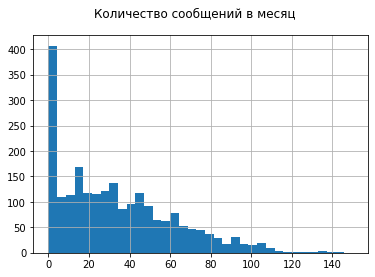

In [25]:
smart_data['messages_amount'].hist(bins=35, range = (0, 150))
plt.suptitle("Количество сообщений в месяц") 


Много пользователей отправляет в месяц меньше 5 сообщений, а бОльшая часть пользователей не превышают лимит в 50 СМС.
Однако, есть часть пользователей, которая превышает лимит почти в 2 раза.

Text(0.5, 0.98, 'Количество Гигабайт в месяц')

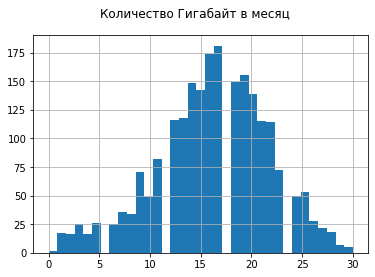

In [26]:
smart_data['gb_used'].hist(bins=35, range = (0, 30))
plt.suptitle("Количество Гигабайт в месяц") 


Пик припадает на уровне 15-18 гб, но много пользователей превышают данный лимит и хвост доходит к 0 только ближе к 30 гб. Превышение лимита происходит в большем количестве случаев, чем в других метриках.

Text(0.5, 0.98, 'Количество минут в месяц')

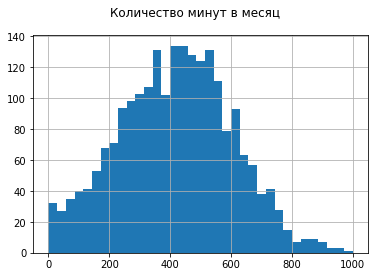

In [27]:
smart_data['calls_duration'].hist(bins=35, range = (0, 1000))
plt.suptitle("Количество минут в месяц") 

Пик использованных минут приходится на лимит в 500 минут, однако большое количество пользователей превышают свой лимит на 100-150 минут.

Вывод по графикам: пользователи тарифа SMART часто выходят за пределы установленных лимитов на тарифе, а значит чаще переплачивают сверх абонентской платы.

### Гистограмы метрик тарифа ULTRA

Text(0.5, 0.98, 'Количество сообщений в месяц')

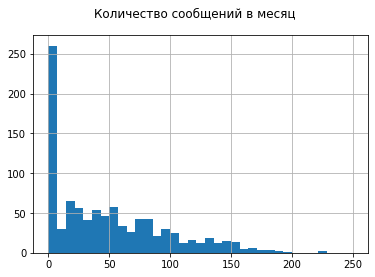

In [28]:
ultra_data['messages_amount'].hist(bins=35, range = (0, 250))
plt.suptitle("Количество сообщений в месяц") 


Все пользователи укладываются в лимит 1000 сообщений.

Text(0.5, 0.98, 'Количество Гигабайт в месяц')

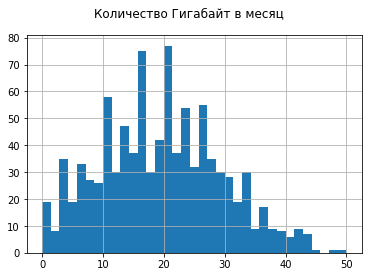

In [29]:
ultra_data['gb_used'].hist(bins=35, range = (0, 50))
plt.suptitle("Количество Гигабайт в месяц") 

Видим, что небольшая часть пользователей не использует интернет.
Пик трафика приходит на 20-23 гб, большая часть пользователей укладывается в рамки 30-ГБ тарифа.

Text(0.5, 0.98, 'Количество минут в месяц')

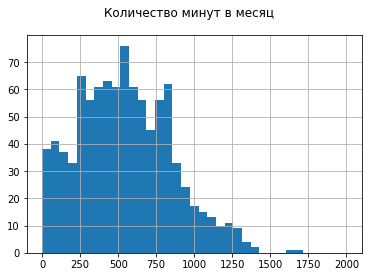

In [30]:
ultra_data['calls_duration'].hist(bins=35, range = (0, 2000))
plt.suptitle("Количество минут в месяц") 

Пик количества минут находится в районе 500-600 минут и держится до 800 минут, далее резкий спад. Лимит в 1000 минут превышает малое количество пользователей.

Вывод по графикам: большая часть пользователей тарифа укладывается в лимиты, заданные в нем. Стоит отметить, что гораздо меньшая часть пользователей, чем в другом тарифе, выходит за рамки ограничений.

## Статистический анализ данных

Проверим две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Так как гипотезы сформулированы таким образом, что не имеет значения в какую именно сторону отличается выручка (в большую или меньшую), то будем использовать логику проверки двухсторонних гипотез.

### Первая гипотеза

Сформулируем нулевую и альтернативную гипотезы:

**Нулевая гипотеза:** средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова

**Альтернативная гипотеза:** средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
    


В Python есть специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind (array1, array2, equal_var)` . Используем его. Если p-value меньше порогового значения alpha, то гипотезу отвергаем. Иначе - не отвергаем. Примем, что пороговое значение равно 5%

In [31]:
alpha = 0.05
 
results = st.ttest_ind(smart_data['total_cost'], ultra_data['total_cost'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Средняя выручка по тарифам - разная.')
else:
    print('Не можем отвергнуть нулевую гипотезу.')

p-значение: 4.657090039411243e-235
Отвергаем нулевую гипотезу. Средняя выручка по тарифам - разная.


Вывод: Малое значение p-value говорит нам о том, вероятность случайного совпадения средних выборок ничтожно мало. Нулевая гипотеза отвергается.

А значит альтернативная гипотеза о том, что средние выборок отличаются, не отвергается.

### Вторая гипотеза

Сформулируем нулевую и альтернативную гипотезы:

**Нулевая гипотеза:** средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов

**Альтернативная гипотеза:** средняя выручка пользователей из Москвы и пользователей из других регионов отличается
    


В Python есть специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind (array1, array2, equal_var)` . Используем его. Если p-value меньше порогового значения alpha, то гипотезу отвергаем. Иначе - не отвергаем. Примем, что пороговое значение равно 5%

In [32]:
moscow_data = total_data.query('city == "Москва"') #создадим таблицу с выборкой данных по Москве
regions_data = total_data.query('city != "Москва"') #и во всех остальных городах в таблице
results_city = st.ttest_ind(moscow_data['total_cost'], regions_data['total_cost'])
print('p-значение:', results_city.pvalue)
if results_city.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не можем отвергнуть нулевую гипотезу.')

p-значение: 0.2251949609364987
Не можем отвергнуть нулевую гипотезу.


Вывод: Полученное p-value равно 0.22, а значит есть некоторая вероятность (выше порогового значения) того, что отличие средних значений наших выборок случайно и мы не можем отвергнуть нулевую гипотезу о равенстве средних значений.

Значит, нашу альтернативную гипотезу о различии средних отвергаем. 

## Вывод

- Тариф Smart выбирают в 2 раза чаще
- Больше всего приносит дополнительного дохода тариф Smart, так как пользователи этого тарифа чаще выходят за лимиты.
- Общая выручка больше всего у тарифа Smart (это объясняется тем, что им пользуется большее количество людей).

- Пользователи тарифа Ultra практически не превышают лимитов, кроме трафика интернета.
- Пользователи тарифа Ultra чаще всего не используют весь лимит по звонкам и сообщениям.

- Самым прибильным сегментом является - интернет, в обоих тарифах. Пользователи двух тарифов используют примерно одинаковые объемы интернета, что говорит об их одинаковом потреблении трафика.
- Оба тарифа редко используют СМС.

Есть основания полагать, что тариф Smart приносит больше дополнительной выручки, а также он более привлекателен для потенциальных пользователей более низкой абонентской платой. С точки зрения рекламных вложений, он выглядит более привлекательным для компании. 

